**Scope:**  
Check whether longer incubation of primary antibody leads to stronger signals.

Plate design:  
https://docs.google.com/spreadsheets/d/1X6NSBpaULj6qFl_G7HlqtHokv0nRJk4Wsy7u1vs9jf0/edit#gid=0

In [1]:
from os.path import join
import numpy as np
from scipy.ndimage import imread
import matplotlib.pyplot as plt
from collections import OrderedDict
from glob import glob
from mi_align import MutualInfoAlignerMultiHypothesis as miamh
import json
import tifffile as tiff
from segmentation_operations import lapgauss_constant
%matplotlib inline

In [2]:
parent_dir0 = "/Volumes/covert-lab/instruments/covert-lab-scope1/scope1dataM/Taka/20170123eTK078/beforestain_1/"
parent_dir = "/Volumes/covert-lab/instruments/covert-lab-scope1/scope1dataM/Taka/20170123eTK078/run_1"

In [83]:
class ImageDict(OrderedDict):
    def __sub__(self, other):
        new = ImageDict()
        for key in self.iterkeys():
            arr = self[key] - other[key]
            arr[arr<0] = 0
            new[key] = arr
        return new

    def stack(self, imdict):
        for key in self.iterkeys():
            if not key in imdict:
                continue
            if self[key].ndim == 3 and imdict[key].ndim == 2:
                imdict[key] = np.expand_dims(imdict[key], axis=2)
            self[key] = np.stack((self[key], imdict[key]), axis=2)

    def return_arr_key(self):
        arr_list = []
        key_list = []
        for key, arr in self.iteritems():
            if arr.ndim == 2:
                arr = np.expand_dims(arr, 2)
            arr_list.append(arr)
            for dim in range(arr.shape[2]):
                key_list.append("r{0}_{1}".format(dim, key))
        arr3d = np.rollaxis(np.dstack(arr_list), axis=2)
        return arr3d, key_list

    def save(self, file_name):
        arr, keys = self.return_arr_key()
        metadata = json.dumps(dict(shape=arr.shape, keys=keys))
        tiff.imsave(file_name, arr.astype(np.float32), description=metadata)

    def load(self, file_name):
        arr, metadata = self._readfile(file_name)
        keys = metadata["keys"]
        chs = [k.split('_')[-1] for k in keys]
        for num, ch in enumerate(chs):
            if not ch in self:
                self[ch] = arr[:, :, num]
            else:
                self[ch] = np.dstack((self[ch], arr[:, :, num]))
    
    def _readfile(self, file_name):
        with tiff.TiffFile(file_name) as tif:
            arr = tif.asarray()
            metadata = tif[0].image_description
        arr = np.moveaxis(arr, 0, -1)
        metadata = json.loads(metadata.decode('utf-8'))
        return arr, metadata

class Field(object):
    def __init__(self, folder, patterns, cnames):
        self.folder = folder
        self.patterns = patterns
        self.cnames = cnames

    def construct(self):
        """ return dict
        """
        images = ImageDict()
        for num, (pi, ci) in enumerate(zip(self.patterns, self.cnames)):
            path = self.read_img_path(self.folder, pi)[0]
            images[ci] = imread(path)
        return images

    def read_img_path(self, folder, pattern):
        return glob(join(folder, pattern))

In [69]:
class ImagesCropper(object):
    """receive Images from ImagesConstructor and then crop it. 
    
    Use calc_jitters() first and then crop().
    """

    def __init__(self, images, DOWNSAMPLE=(8, 4, 2)):
        self.images = images
        self.DOWNSAMPLE = DOWNSAMPLE

    def calc_jitters(self):
        """Calculate MI for all channels and pick one alignment with the maximum MI. 
        """
        images = self.images
        jitters = [(0, 0)]  # the first image is the standard
        for dim in range(images[images.keys()[0]].shape[2]-1):
            ji_store, mi_store = [], []
            for ch in images.keys():
                img1 = images[ch][:, :, 0]
                img2 = images[ch][:, :, dim+1]
                mi = miamh(img1, img2, DOWNSAMPLE=self.DOWNSAMPLE)
                mi.execute()
                ji_store.append((mi._j, mi._i))
                mi_store.append(mi.mi)
            print ji_store[mi_store.index(max(mi_store))]
            jitters.append(ji_store[mi_store.index(max(mi_store))])
        self.jitters = jitters
        
    def crop_multiimages(self, img_list, jit_list):
        """
            img_list (List(np.ndarray)): a list of images
            jit_list (List(tuple)): tuple contains jitters e.g. (-5, 5)

        >> im_list = [np.ones((4, 4)), np.ones((4, 4)), np.ones((4, 4))]
        >> ji_list = [(0, 0), (1, 1), (-1, -1)]
        >> crop_common(im_list, ji_list).shape
        (2, 2, 3)
        """
        IMG_NUM = len(img_list)
        s0, s1 = img_list[0].shape[0], img_list[0].shape[1]
        template = np.ones((s0*3, s1*3, IMG_NUM)) * np.Inf
        for num, (img, jit) in enumerate(zip(img_list, jit_list)):
            template[s0+jit[1]:s0*2+jit[1], s1+jit[0]:s1*2+jit[0], num] = img
        x, y = np.where(-(np.isinf(np.max(template, axis=2))))
        xmin, xmax = x.min(), x.max()
        ymin, ymax = y.min(), y.max()
        return template[xmin:xmax+1, ymin:ymax+1, :]

    def crop_images(self, images, jit_list):
        new_images = {}
        for ch, img in images.iteritems():
            imlist = [img[:, :, num] for num in range(img.shape[2])]
            new_images[ch] = self.crop_multiimages(imlist, jit_list)
        return new_images

    def crop(self):
        return self.crop_images(self.images, self.jitters)

class ImagesCropperNuc(ImagesCropper):
    """
    Use DOWNSAMPLE=(8, 4, 2) if not work.
    """
    def __init__(self, images, nucimg, DOWNSAMPLE=(16, 8, 4, 2)):
        self.images = images
        self.nucimg = nucimg
        self.DOWNSAMPLE = DOWNSAMPLE

    def calc_jitters(self):
        """Calculate MI for all channels and pick one alignment with the maximum MI. 
        """
        self._ji_store, self._mi_store = [], []
        images = self.images
        jitters = [(0, 0)]  # the first image is the standard
        for dim in range(images[images.keys()[0]].shape[2]):
            ji_store, mi_store = [], []
            for ch in images.keys():
                img1 = self.nucimg.copy()
                img2 = images[ch][:, :, dim]
                x, y = np.ceil(img1.shape[0]/5), np.ceil(img1.shape[1]/5)                
                mi = miamh(img1, img2, DOWNSAMPLE=self.DOWNSAMPLE)
                mi.execute()
                ji_store.append((mi._j, mi._i))
                mi_store.append(mi.mi)
            print ji_store[mi_store.index(max(mi_store))]
            jitters.append(ji_store[mi_store.index(max(mi_store))])
            self._ji_store.append(ji_store)
            self._mi_store.append(mi_store)
        self.jitters = jitters

    def crop_images(self, images, jit_list):
        new_images = ImageDict()
        for num, (ch, img) in enumerate(images.iteritems()):
            imlist = [img[:, :, num] for num in range(img.shape[2])]
            imlist.insert(0, self.nucimg.copy())
            arr = self.crop_multiimages(imlist, jit_list)
            new_images[ch] = arr[:, :, 1:]
            crop_nucimg = arr[:, :, 0]
        return new_images, crop_nucimg

In [71]:
nucimg = f0['AMCA'][:,:, 0]
icn = ImagesCropperNuc(f0, nucimg, DOWNSAMPLE=(4, 2))

In [72]:
# icn.calc_jitters()
icn.jitters = [(0, 0), (0, 0), (11, 8)]

In [73]:
cc = icn.crop()

/Users/kudo/.pyenv/versions/anaconda-2.4.0/envs/covertrack/lib/python2.7/site-packages/ipykernel/__main__.py:44: DeprecationWarning: numpy boolean negative, the `-` operator, is deprecated, use the `~` operator or the logical_not function instead.


In [74]:
import png
png.from_array(cc[0]['DAPI'][:,:,0].astype(np.uint16), 'L').save('test1.png')
png.from_array(cc[0]['DAPI'][:,:,1].astype(np.uint16), 'L').save('test2.png')


## A078 plot

In [75]:
import tempfile
import urllib
temp_dir= tempfile.mkdtemp()
urllib.urlretrieve('http://archive.simtk.org/ktrprotocol/temp/lu_weight.npy', join(temp_dir, 'lu_weight.npy'))
weight = np.load(join(temp_dir, 'lu_weight.npy'))
urllib.urlretrieve('http://archive.simtk.org/ktrprotocol/temp/bg_hela.npy', join(temp_dir, 'bg_hela.npy'))
bg_hela = np.load(join(temp_dir, 'bg_hela.npy'))


In [76]:
def unmixing(field, weight):
    corr_field = ImageDict()
    stacked = np.vstack([i.ravel() for i in field.itervalues()])
    corrected = np.dot(np.linalg.inv(weight), stacked)
    for num, key in enumerate(field.iterkeys()):
        vec = corrected[num, :]
        vec[vec < 0] = 0
        corr_field[key] = vec.reshape(field[key].shape)
    return corr_field

In [77]:
patterns = ['*channel006*', '*channel007*', '*channel000*', '*channel001*', '*channel008*', '*channel003*', '*channel004*', '*channel005*']
colors = ['AMCA', 'DAPI', 'CFP', 'FITC', 'Orange', 'TRITC', 'Cherry', 'Farred']

In [95]:
f0 = Field(join(parent_dir0, 'B4_Site_1'), patterns, colors).construct()
f = Field(join(parent_dir, 'B5_Site_1'), patterns, colors).construct()
bg_h = ImageDict()
for num, c in enumerate(colors):
    bg_h[c] = bg_hela[:, :, num]

In [96]:
from segmentation_operations import constant_lap_edge
nuc = constant_lap_edge(f0['AMCA'], None, THRES=200, NUCRAD=15)

In [97]:
ff = f - bg_h
unff = unmixing(ff, weight)
unff0 = f0 - bg_h
unff0 = unmixing(unff0, weight)

In [98]:
# unff0['nuc'] = nuc

In [99]:
unff0.stack(unff)

In [100]:
unff0.save('test.tif')

In [101]:


a = ImageDict()
a.load('test.tif')

In [108]:
icn = ImagesCropperNuc(unff0, nuc, DOWNSAMPLE=(4, 2))
icn.jitters = [(0, 0), (0, 0), (11, 8)]
cc = icn.crop()

/Users/kudo/.pyenv/versions/anaconda-2.4.0/envs/covertrack/lib/python2.7/site-packages/ipykernel/__main__.py:44: DeprecationWarning: numpy boolean negative, the `-` operator, is deprecated, use the `~` operator or the logical_not function instead.


In [106]:
cc.save('test1.tif')

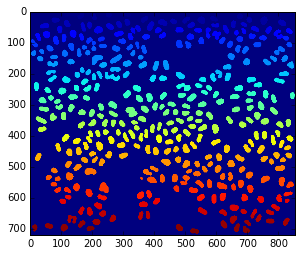

In [93]:
plt.imshow(a['nuc'])